In [6]:
from transformers import Wav2Vec2Processor, HubertForCTC
import torch
import torchaudio
import os

In [7]:
# Path to the TIMIT dataset audio file
audio_file = os.path.join("timit", "data", "TRAIN", "DR1", "FCJF0", "SA1.WAV")

# Load the audio file
waveform, sample_rate = torchaudio.load(audio_file)
waveform = waveform.squeeze()

# Resample to 16kHz if necessary
if sample_rate != 16000:
    waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)

In [8]:

# Load the Hubert processor and model
hubert_processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
hubert_model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft")

# Process and tokenize the waveform
inputs = hubert_processor(waveform, sampling_rate=16000, return_tensors="pt")

# Get the predicted text from the Hubert model
with torch.no_grad():
    logits = hubert_model(inputs.input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)

ground_truth_text = "She had your dark suit in greasy wash water all year"

# Decode the predicted ids to text
predicted_text = hubert_processor.batch_decode(predicted_ids)[0]
print("Hubert Predicted Text:", predicted_text)


d:\Anaconda\Lib\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map_location)

Hubert Predicted Text: SHE HAD YOUR DUCK SUIT AN GREASY WASHWATER ALL YEAR


Word Error Rate: 0.36363636363636365
Match Error Rate: 0.36363636363636365
Word Information Lost Rate: 0.5545454545454546


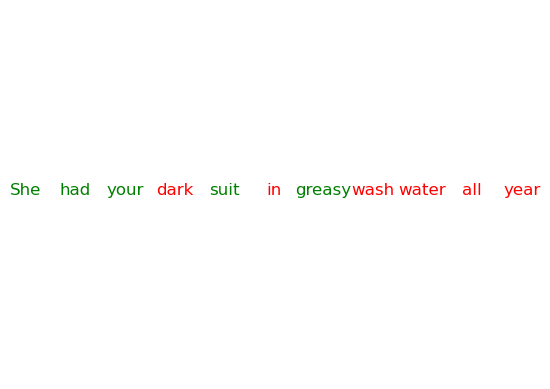

In [9]:
from jiwer import wer, mer, wil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

error_rate = wer(ground_truth_text.lower(), predicted_text.lower())
print("Word Error Rate:", error_rate)

match_error_rate = mer(ground_truth_text.lower(), predicted_text.lower())
wil_rate = wil(ground_truth_text.lower(), predicted_text.lower())
print("Match Error Rate:", match_error_rate)
print("Word Information Lost Rate:", wil_rate)

def visualize_pronunciation(ground_truth, prediction):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()
    
    fig, ax = plt.subplots()
    for idx, word in enumerate(ground_truth_words):
        color = 'green' if idx < len(predicted_words) and word.lower() == predicted_words[idx].lower() else 'red'
        ax.text(idx * 0.1, 0.5, word, color=color, fontsize=12, ha='center')
    ax.axis('off')
    plt.show()

visualize_pronunciation(ground_truth_text, predicted_text)

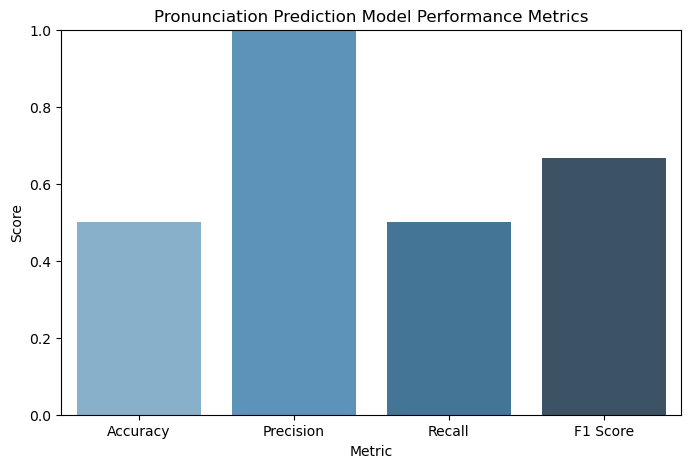

In [10]:

def plot_performance_metrics(accuracy, precision, recall, f1):
    metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")
    plt.ylim(0, 1)
    plt.title("Pronunciation Prediction Model Performance Metrics")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_labels(ground_truth, prediction):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()
    labels = [1 if gt.lower() == pd.lower() else 0 for gt, pd in zip(ground_truth_words, predicted_words)]
    return labels

labels = get_labels(ground_truth_text, predicted_text)

accuracy = accuracy_score([1]*len(labels), labels)
precision = precision_score([1]*len(labels), labels)
recall = recall_score([1]*len(labels), labels)
f1 = f1_score([1]*len(labels), labels)

plot_performance_metrics(accuracy, precision, recall, f1)
